In [1]:
from sklearn.metrics import roc_auc_score
from scipy.io import loadmat
import numpy as np
import os

def roc(idd, ood, order=0):
    idd = np.squeeze(idd)
    ood = np.squeeze(ood)
    if order == 0:
        y_true = np.concatenate((np.ones_like(idd), np.zeros_like(ood)), axis=0)
    elif order == 1:
        y_true = np.concatenate((np.zeros_like(idd), np.ones_like(ood)), axis=0)
    y_pred = np.concatenate((idd, ood), axis=0)
    auc = roc_auc_score(y_true, y_pred)
    return auc

def add_mean(x):
    weights = ~np.eye(x.shape[0],x.shape[1]).astype('bool')
    weights = weights.astype('float32')
    y = np.concatenate((x, np.expand_dims(np.mean(x.T[~np.eye(x.shape[0],x.shape[1]).astype('bool')].reshape(x.shape[0]-1,x.shape[1],order='F'), axis=0), axis=0)), axis=0)
    return y

def find_range(x):
    weights = ~np.eye(x.shape[0],x.shape[1]).astype('bool')
    weights = weights.astype('float32')
    y = np.concatenate((np.expand_dims(np.min(x.T[~np.eye(x.shape[0],x.shape[1]).astype('bool')].reshape(x.shape[0]-1,x.shape[1],order='F'), axis=0),axis=0),
                        np.expand_dims(np.max(x.T[~np.eye(x.shape[0],x.shape[1]).astype('bool')].reshape(x.shape[0]-1,x.shape[1],order='F'), axis=0),axis=0)), axis=0)
    return y

datasets = [
    'mnist',
    'fashion_mnist',
    'emnist/letters',
    'sign_lang',
    'noise'
]

norms = ['ec_bm/original_rotated_inv_diff', 'ec_bm/original_rotated_inv_diff']

labels = ['AllRot-LL', 'PatchShuffle-LL']


order = np.zeros(len(norms))

all_probs = {}

for i, norm in enumerate(norms):
    globals()['tmp_'+str(i)] = np.zeros((len(datasets), len(datasets))) # row - ood, col - id
    for j, id_set in enumerate(datasets[:-1]):
        if id_set == 'emnist/letters':
            id_set1 = 'emnist_letters'
        else:
            id_set1 = id_set
        if os.path.exists('../probs/' + norm + '/' + id_set1 + '.mat'):
            probs = loadmat('../probs/' + norm + '/' + id_set1 + '.mat')
            for k, ood_set in enumerate(datasets):
                if ood_set in probs:
                    globals()['tmp_'+str(i)][k,j] = roc(probs[id_set], probs[ood_set], order=order[i])
                else:
                    globals()['tmp_'+str(i)][k,j] = 0
        else:
            for k in range (len(datasets)):
                globals()['tmp_'+str(i)][k,j] = 0
    globals()['tmp_'+str(i)+'_range'] = find_range(globals()['tmp_'+str(i)])
    globals()['tmp_'+str(i)] = add_mean(globals()['tmp_'+str(i)])

/tmp/ipykernel_2976629/3859660419.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_2976629/3859660419.py:116: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(save_dir + 'plot_ll_gray.pdf', dpi=300, bbox='tight')


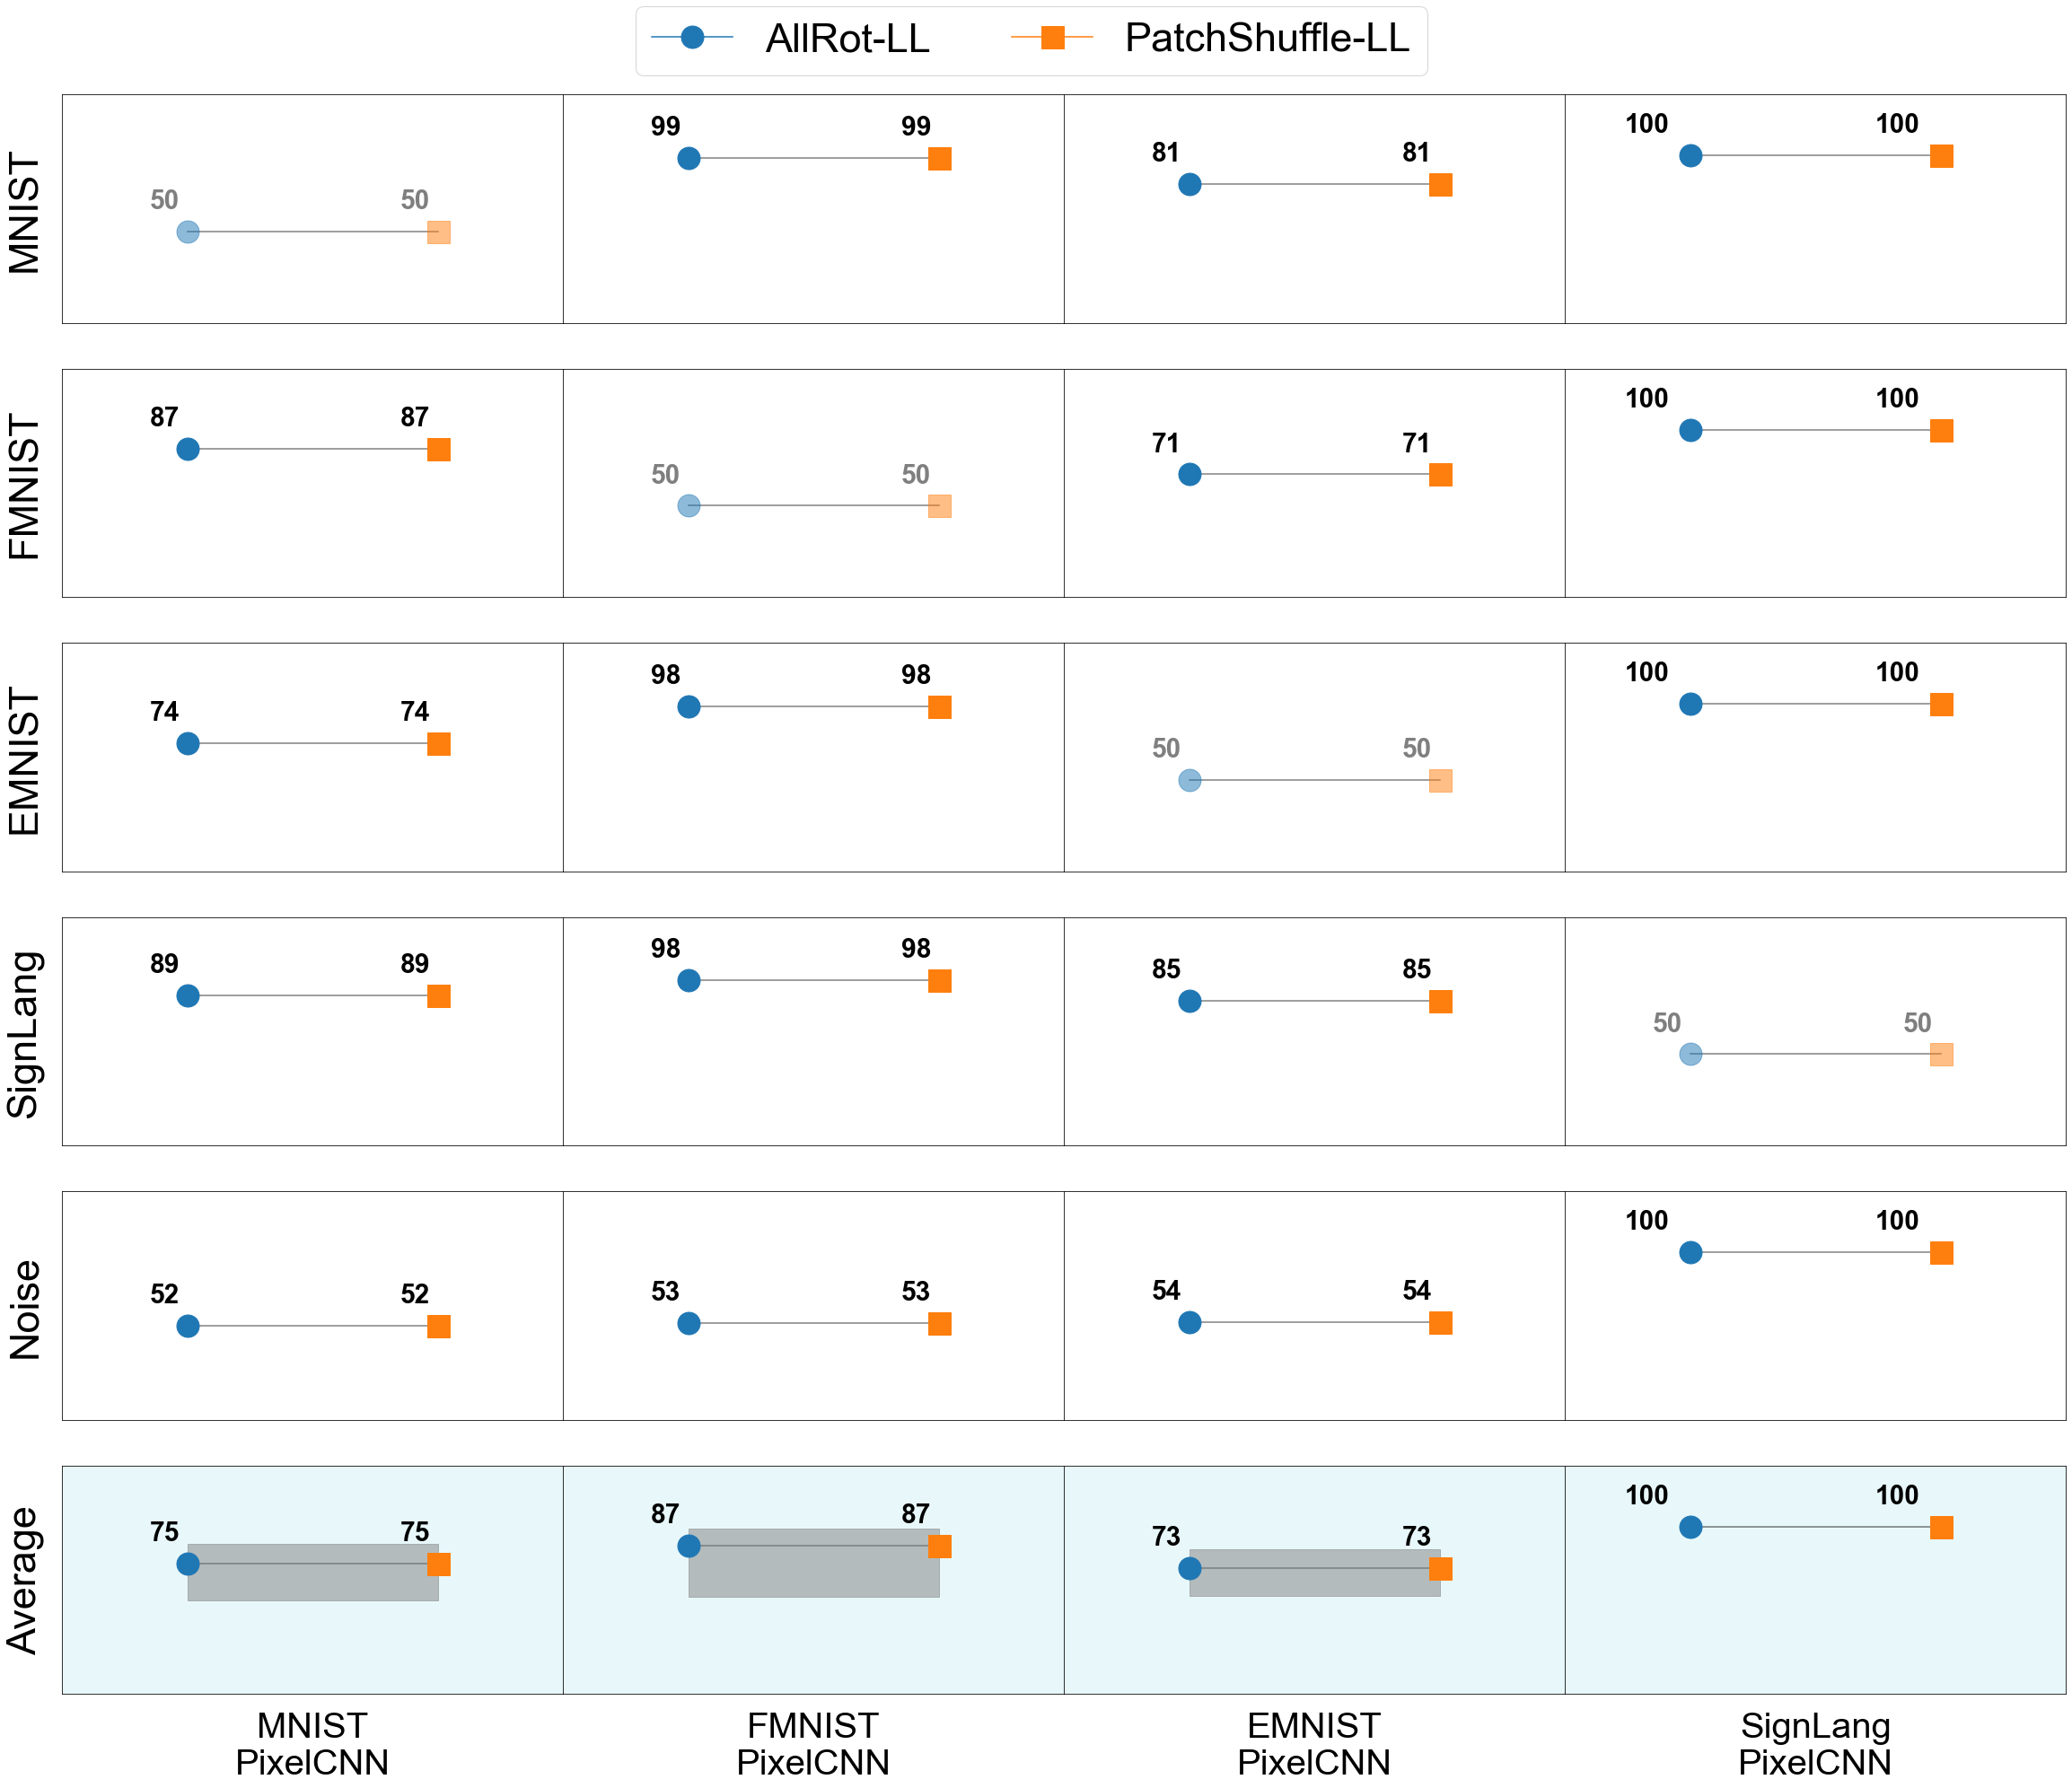

In [2]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import os

num = len(norms)

x = np.arange(num).astype('float32')
a = np.concatenate((
        np.expand_dims(tmp_0,axis=0),
        np.expand_dims(tmp_1,axis=0),
    ), axis = 0)

ran = np.concatenate((
        np.expand_dims(tmp_0_range,axis=0),
        np.expand_dims(tmp_1_range,axis=0),
    ), axis = 0)

for i in range(len(norms)):
    if i > 1:
        a = np.concatenate((a, np.expand_dims(globals()['tmp_'+str(i)], axis=0)), axis=0)
        ran = np.concatenate((ran, np.expand_dims(globals()['tmp_'+str(i)+'_range'], axis=0)), axis=0)

ytitles = ['MNIST', 'FMNIST', 'EMNIST', 'SignLang', 'Noise', 'Average']
heights = [2,2,2,2,2,2]
size = 6

marksize = 25

plt.rcParams["figure.figsize"] = (40,30)
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig = plt.figure()

markers = ['o', 's', 'X', '>', '^', 'P', 'D', '*']

labels_list = []
for i in range (len(norms)):
    labels_list.append(mlines.Line2D([], [], label=labels[i], color=sns.color_palette()[i], marker=markers[i], markersize=marksize))

# legend = fig.legend(handles=labels_list
#                     , bbox_to_anchor=(0., 0.96, 1., .1), loc='lower center',
#            ncol=int(np.ceil(num/2)) if num >=6 else num, borderaxespad=0., bbox_transform=fig.transFigure, fontsize=45)

legend = fig.legend(handles=labels_list
                    , bbox_to_anchor=(0., 0.96, 1., .1), loc='lower center',
           ncol=num, borderaxespad=0., bbox_transform=fig.transFigure, fontsize=45)

widths = [4,4,4,4]
gs = fig.add_gridspec(size, size-2, width_ratios=widths, height_ratios=heights, hspace=0.2, wspace=0)
ax = gs.subplots(sharex='col', sharey='row')

xoff = 0.15
yoff = 0.15
font = 30
   
breaks = [3]

for i in range (size):
    for j in range (size-2):
        
        if i == j:
            alpha = 0.5
        else:
            alpha = 1

        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].set_xlim([-0.5, num-0.5])
        ax[i,j].set_ylim([-0.1,1.4])
        
        if len(breaks) == 0:
            ax[i,j].plot(x,np.squeeze(a[:,i,j]), alpha=0.5, color='k', zorder=1)
        else:
            ax[i,j].plot(x[:breaks[0]],np.squeeze(a[:breaks[0],i,j]), alpha=0.5, color='k', zorder=1)
            for m in breaks:
                ax[i,j].plot(x[m:],np.squeeze(a[m:,i,j]), alpha=0.5, color='k', zorder=1)
                
        if j == 0:
            ax[i,j].set_ylabel(ytitles[i], fontsize=45, labelpad=20)

        for k in range (num):
            ax[i,j].errorbar(x[k],np.squeeze(a[k,i,j]), yerr=0, color=sns.color_palette()[k], marker=markers[k], markersize=marksize, alpha=alpha, zorder=2)
            
            if (np.round(np.squeeze(a[k,i,j]),2)*100).astype('int') == max((np.round(np.squeeze(a[:,i,j]),2)*100).astype('int')):
                if (np.round(np.squeeze(a[k,i,j]),2)*100).astype('int') == 100:
                    ax[i,j].text(x[k]-xoff-0.11, np.squeeze(a[k,i,j])+yoff, (np.round(np.squeeze(a[k,i,j]),2)*100).astype('int'), fontsize = font, alpha=alpha,
                               fontweight='extra bold')
                else:
                    ax[i,j].text(x[k]-xoff, np.squeeze(a[k,i,j])+yoff, (np.round(np.squeeze(a[k,i,j]),2)*100).astype('int'), fontsize = font, alpha=alpha,
                               fontweight='extra bold')
            else:
                ax[i,j].text(x[k]-xoff, np.squeeze(a[k,i,j])+yoff, (np.round(np.squeeze(a[k,i,j]),2)*100).astype('int'), fontsize = font, alpha=alpha)

        if i==(size-1):
            if len(breaks) == 0:
                ax[i,j].fill_between(x, ran[:,1,j], ran[:,0,j], color='grey', alpha=0.5)
            else:
                ax[i,j].fill_between(x[:breaks[0]], ran[:breaks[0],1,j], ran[:breaks[0],0,j], color='grey', alpha=0.5)
                for m in breaks:
                    ax[i,j].fill_between(x[m:], ran[m:,1,j], ran[m:,0,j], color='grey', alpha=0.5)
            ax[i,j].set_xticks([])
#             ax[i,j].set_xticks(x)
#             ax[i,j].set_xticklabels(labels ,fontsize=20)
            ax[i,j].set_xlabel(ytitles[j] + '\nPixelCNN', fontsize=40, labelpad=20)
            ax[i,j].set_facecolor((0.90901961, 0.9745098 , 0.98117647))

fig.subplots_adjust(top=0.95)
fig.tight_layout()
save_dir = '../plots/rotations/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fig.savefig(save_dir + 'plot_ll_gray.pdf', dpi=300, bbox='tight')